In [188]:
import csv
import numpy as np
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

In [187]:
def load_data(filepath):
    all_data = []
    with open(filepath, newline='') as f:
        freader = csv.DictReader(f)
        for row in freader:
            all_data.append(dict(row))
    return all_data

In [4]:
data = load_data('./countries.csv')
print(data)

[{'': '0', 'Country': 'Afghanistan ', 'Population': '31056997', 'Net migration': '23.06', 'GDP ($ per capita)': '700.0', 'Literacy (%)': '36.0', 'Phones (per 1000)': '3.2', 'Infant mortality (per 1000 births)': '163.07'}, {'': '1', 'Country': 'Albania ', 'Population': '3581655', 'Net migration': '-4.93', 'GDP ($ per capita)': '4500.0', 'Literacy (%)': '86.5', 'Phones (per 1000)': '71.2', 'Infant mortality (per 1000 births)': '21.52'}, {'': '2', 'Country': 'Algeria ', 'Population': '32930091', 'Net migration': '-0.39', 'GDP ($ per capita)': '6000.0', 'Literacy (%)': '70.0', 'Phones (per 1000)': '78.1', 'Infant mortality (per 1000 births)': '31'}, {'': '3', 'Country': 'American Samoa ', 'Population': '57794', 'Net migration': '-20.71', 'GDP ($ per capita)': '8000.0', 'Literacy (%)': '97.0', 'Phones (per 1000)': '259.5', 'Infant mortality (per 1000 births)': '9.27'}, {'': '4', 'Country': 'Andorra ', 'Population': '71201', 'Net migration': '6.6', 'GDP ($ per capita)': '19000.0', 'Literacy 

In [219]:
def calc_features(row):
    x1 = float(row['Population'])
    x2 = float(row['Net migration'])
    x3 = float(row['GDP ($ per capita)'])
    x4 = float(row['Literacy (%)'])
    x5 = float(row['Phones (per 1000)'])
    x6 = float(row['Infant mortality (per 1000 births)'])
    return np.array([x1, x2, x3, x4, x5, x6], dtype='float64')
    pass

In [220]:
first_country = calc_features(data[1])
print(first_country.shape)
print(first_country)
print(first_country.dtype)

(6,)
[ 3.581655e+06 -4.930000e+00  4.500000e+03  8.650000e+01  7.120000e+01
  2.152000e+01]
float64


In [6]:
def distance(feat_1, feat_2):
    temp = feat_1 - feat_2
    sum_eq = np.dot(temp.T, temp)
    return(np.sqrt(sum_eq))

In [324]:
def hac(features):
    total_feat = len(features)
    cluster_list = np.arange(total_feat).reshape(-1, 1).tolist()
    cluster_distance_matrix = np.zeros((total_feat, total_feat))
    clustered_countries = set()
    Z = np.zeros((total_feat - 1, 4))
    
    # Populate initial distances
    for ii in range(total_feat):
        for jj in range(ii, total_feat):
            cluster_distance_matrix[ii][jj] = cluster_distance_matrix[jj][ii] = np.linalg.norm(features[ii] - features[jj])

    # cluster_distance_matrix = np.array([[0, 17, 21, 31, 23], [17, 0, 30, 34, 21], [21, 30, 0 , 28, 39], [31, 34, 28, 0, 43], [23, 21, 39, 43, 0]], dtype=float)

    print(cluster_distance_matrix)
    for clustering_idx in range(total_feat - 1):
        smallest_dist = float('inf')
        idx_1 = idx_2 = -1
        
        # Find the closest pair of clusters
        ii_len = jj_len = -1
        ii_idx = jj_idx = -1
        for ii in range(total_feat):
            for jj in range(ii+1, total_feat):
                # print(f"cluster_distance_matrix is {cluster_distance_matrix[ii][jj]} and smallest_dist is {smallest_dist}, {cluster_distance_matrix[ii][jj] < smallest_dist}")
                if cluster_distance_matrix[ii][jj] < smallest_dist:
                    smallest_dist = cluster_distance_matrix[ii][jj]
                    idx_1 = ii
                    idx_2 = jj
                # We consider each country to be its own cluster == we create a cluster of x+y
                # From the reverse side, check if one of the cluster is already part of another cluster
                for each_cluster in reversed(cluster_list):
                    if idx_1 in each_cluster:
                        # print(f"found the index {idx_1} in cluster {each_cluster}")
                        ii_len = len(each_cluster)
                        # print(f"ii_len is {ii_len}")
                        ii_idx = cluster_list.index(each_cluster)
                        break
                for each_cluster in reversed(cluster_list):
                    if idx_2 in each_cluster:
                        # print(f"found the index {idx_2} in cluster {each_cluster}")
                        jj_len = len(each_cluster)
                        # print(f"jj_len is {jj_len}")
                        jj_idx = cluster_list.index(each_cluster)
                        break
                if ii_idx == jj_idx:
                    continue

        print("Merging the indices {} and {} with distance {}".format(idx_1, idx_2, smallest_dist))
        cluster_distance_matrix[idx_1][idx_2] = cluster_distance_matrix[idx_2][idx_1] = float('inf')
        # print(f"Cluster at iith index {ii_idx} is {cluster_list[ii_idx]} and cluster at jjth index {jj_idx} is {cluster_list[jj_idx]}")
        # print(f"the combination of these clusters is {cluster_list[ii_idx] + cluster_list[jj_idx]}")
        updated_cluster = cluster_list[ii_idx] + cluster_list[jj_idx]
        for ii in cluster_list[ii_idx]:
            for jj in cluster_list[jj_idx]:
                # Update the distance between the current cluster to infinite (We dont want to merge them again)
                cluster_distance_matrix[jj][ii] = cluster_distance_matrix[ii][jj] = float('inf')
        cluster_list.append(updated_cluster)

        # Update Z with merging information
        Z[clustering_idx, 0] = min(ii_idx, jj_idx)
        Z[clustering_idx, 1] = max(ii_idx, jj_idx)
        Z[clustering_idx, 2] = smallest_dist
        total_len = ii_len + jj_len
        # print(f"THE TOTAL LENGTH OF TH CLUSTER NOW IS {total_len}")
        Z[clustering_idx, 3] = total_len
        # print(cluster_distance_matrix)
        
        # Merge the clusters
        clustered_countries.add(idx_1)
        clustered_countries.add(idx_2)
        
        # Update the cluster distance matrix
        for updater in range(total_feat):
            for index_1 in cluster_list[ii_idx]:
                for index_2 in cluster_list[jj_idx]:
                    cluster_distance_matrix[index_1][updater] = cluster_distance_matrix[updater][index_1] = cluster_distance_matrix[index_2][updater] = cluster_distance_matrix[updater][index_2] = max(cluster_distance_matrix[index_1][updater], cluster_distance_matrix[index_2][updater])
        print(f"At the end of iteration {clustering_idx}, the distance matrix is:")
        print(cluster_distance_matrix)
    return Z

In [256]:
def new_hac(features):
    total_feat = len(features)
    cluster_list = np.arange(total_feat).reshape(-1, 1).tolist()
    cluster_distance_matrix = np.zeros((total_feat, total_feat))
    clustered_countries = set()
    Z = np.zeros((total_feat - 1, 4))
    
    # Populate initial distances
    for ii in range(total_feat):
        for jj in range(ii + 1):
            dist = np.linalg.norm(features[ii] - features[jj])
            cluster_distance_matrix[ii][jj] = cluster_distance_matrix[jj][ii] = dist

    for clustering_idx in range(total_feat - 1):
        smallest_dist = float('inf')
        idx_1 = idx_2 = -1
        
        # Find the closest pair of clusters
        for ii in range(total_feat):
            for jj in range(ii):
                if cluster_distance_matrix[ii][jj] < smallest_dist:
                    smallest_dist = cluster_distance_matrix[ii][jj]
                    idx_1 = ii
                    idx_2 = jj

        # Merge the clusters
        merged_cluster = cluster_list[idx_1] + cluster_list[idx_2]
        cluster_list.append(merged_cluster)
        
        # Update Z with merging information
        Z[clustering_idx, 0] = idx_1
        Z[clustering_idx, 1] = idx_2
        Z[clustering_idx, 2] = smallest_dist
        Z[clustering_idx, 3] = len(merged_cluster)
        
        # Update the cluster distance matrix
        for updater in range(total_feat):
            if updater != idx_1 and updater != idx_2:
                cluster_distance_matrix[idx_1][updater] = cluster_distance_matrix[updater][idx_1] = cluster_distance_matrix[idx_2][updater] = cluster_distance_matrix[updater][idx_2] = max(cluster_distance_matrix[idx_1][updater], cluster_distance_matrix[idx_2][updater])
        
        # Update distances with the new merged cluster
        for ii in range(total_feat):
            if ii != idx_1 and ii != idx_2:
                cluster_distance_matrix[clustering_idx][ii] = cluster_distance_matrix[ii][clustering_idx] = np.linalg.norm(features[merged_cluster[0]] - features[ii])

    return Z

In [287]:
def fig_hac(Z, names):
    dendrogram(Z, labels=names, leaf_rotation=90)
    plt.title('Dendrogram')
    plt.xlabel('Countries')
    plt.ylabel('Distance')
    plt.show()

In [328]:
def normalize_vectors(features):
    means = np.mean(features, axis=0)
    std_dev = np.std(features, axis=0)
    return (features - means) / std_dev

[[       0.         27475342.26329052  1873101.50488285 ...
  13402154.01850843 26562249.8487296  19674177.12386815]
 [27475342.26329052        0.         29348436.03833987 ...
  14073188.34175975   913114.44254185  7801165.16410142]
 [ 1873101.50488285 29348436.03833987        0.         ...
  15275248.69288486 28435342.37415708 21547271.22302942]
 ...
 [13402154.01850843 14073188.34175975 15275248.69288486 ...
         0.         13160097.22239286  6272023.18039472]
 [26562249.8487296    913114.44254185 28435342.37415708 ...
  13160097.22239286        0.          6888075.31249202]
 [19674177.12386815  7801165.16410142 21547271.22302942 ...
   6272023.18039472  6888075.31249202        0.        ]]
Merging the indices 4 and 7 with distance 8269.45870783572
At the end of iteration 0, the distance matrix is:
[[       0.         27475342.26329052  1873101.50488285 ...
  13402154.01850843 26562249.8487296  19674177.12386815]
 [27475342.26329052        0.         29348436.03833987 ...
  140

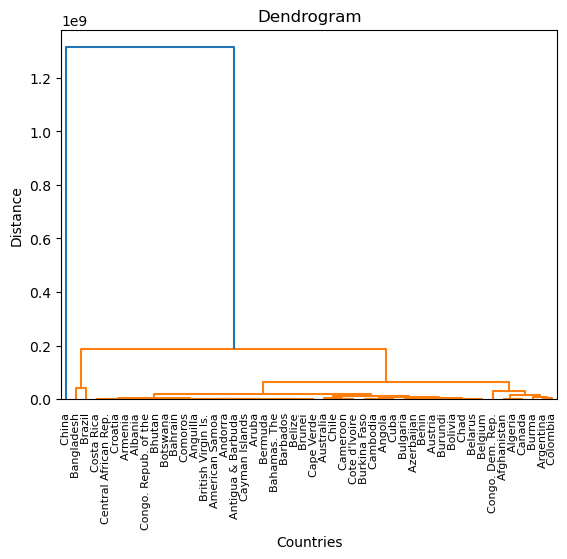

[[0.         6.09471288 5.1763968  ... 4.13839591 6.19767158 6.13537261]
 [6.09471288 0.         1.10494853 ... 2.4972867  2.05882871 0.82761072]
 [5.1763968  1.10494853 0.         ... 1.76215399 2.16656098 1.44178043]
 ...
 [4.13839591 2.4972867  1.76215399 ... 0.         3.60546015 2.96798341]
 [6.19767158 2.05882871 2.16656098 ... 3.60546015 0.         1.77484037]
 [6.13537261 0.82761072 1.44178043 ... 2.96798341 1.77484037 0.        ]]
Merging the indices 38 and 47 with distance 0.0958875852194229
At the end of iteration 0, the distance matrix is:
[[0.         6.09471288 5.1763968  ... 4.13839591 6.19767158 6.13537261]
 [6.09471288 0.         1.10494853 ... 2.50895491 2.05882871 0.82761072]
 [5.1763968  1.10494853 0.         ... 1.78544571 2.16656098 1.44178043]
 ...
 [4.13839591 2.50895491 1.78544571 ...        inf 3.63791137 2.97523227]
 [6.19767158 2.05882871 2.16656098 ... 3.63791137 0.         1.77484037]
 [6.13537261 0.82761072 1.44178043 ... 2.97523227 1.77484037 0.        ]

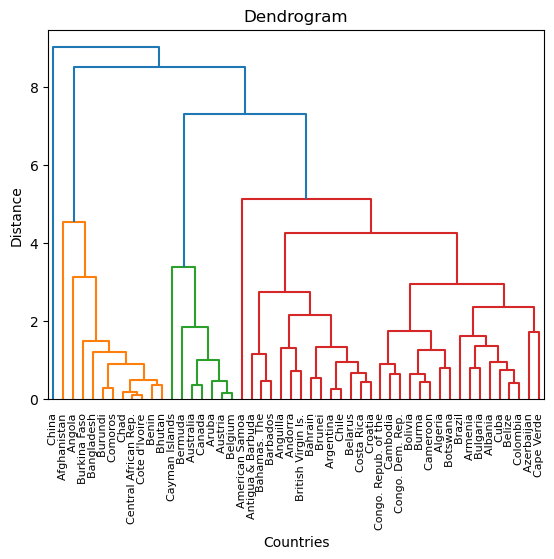

In [329]:
data = load_data("./countries.csv")
country_names = [row["Country"] for row in data]
features = [calc_features(row) for row in data]
# features_normalized = normalize_features(features)
n = 50
Z_raw = hac(features[:n])
fig1 = fig_hac(Z_raw, country_names[:n])
# print(features_normalized)
features_normalized = normalize_vectors(features[:n])
# print(features[])
# print(features[-9])
# print(distance(features[-10], features[-9]))
Z_normalized = hac(features_normalized[:n])
print(Z_normalized)
fig = fig_hac(Z_normalized, country_names[:n])